In [1]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pulp
import time

# === Chargement des données ===
df = pd.read_csv(r"../data/matrice_routes_ordre_50.csv", header=None)

# Lire les points de collecte depuis la dernière ligne
collect_line = df.iloc[-1, 0]
points_collecte = list(map(int, collect_line.split(';')))
points_collecte = [p - 1 for p in points_collecte]  # base 1 → base 0
non_collecte = [i for i in range(len(df) - 1) if i not in points_collecte]

# Nettoyer la matrice
df = df.iloc[:-1]
adj_matrix = df[0].str.split(';').apply(lambda x: list(map(int, x)))
cost_matrix = pd.DataFrame(adj_matrix.tolist())
INF = 10**6
cost_matrix = cost_matrix.replace(-1, INF)
n = cost_matrix.shape[0]

# === Modèle MILP ===
prob = pulp.LpProblem("TSP_with_Collecte_Constraints", pulp.LpMinimize)
x = pulp.LpVariable.dicts("x",
    ((i, j) for i in range(n) for j in range(n)
     if i != j and cost_matrix.iloc[i, j] < INF), cat='Binary')
u = pulp.LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

# Objectif
prob += pulp.lpSum(cost_matrix.iloc[i, j] * x[i, j] for (i, j) in x)

# Visite unique
for i in range(n):
    prob += pulp.lpSum(x[i, j] for j in range(n) if (i, j) in x) == 1
    prob += pulp.lpSum(x[j, i] for j in range(n) if (j, i) in x) == 1

# Sous-tours (MTZ)
for i in range(1, n):
    for j in range(1, n):
        if i != j and (i, j) in x:
            prob += u[i] - u[j] + n * x[i, j] <= n - 1

# ✅ Contrainte : départ → point de collecte
prob += pulp.lpSum(x[0, j] for j in points_collecte if (0, j) in x) == 1

# ✅ Contrainte : retour ← ville non-collecte
prob += pulp.lpSum(x[i, 0] for i in non_collecte if (i, 0) in x) == 1

# === Résolution chronométrée ===
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=300)
start_time = time.time()
prob.solve(solver)
end_time = time.time()
elapsed = end_time - start_time

# === Reconstruction de la tournée ===
tour_dict = {i: j for (i, j) in x if pulp.value(x[i, j]) > 0.5}
start = 0
tour = [start]
while True:
    next_city = tour_dict.get(tour[-1])
    if next_city is None or next_city == start:
        break
    tour.append(next_city)
tour.append(start)

# === Affichage ===
print("📊 Statut :", pulp.LpStatus[prob.status])
print(f"⏱️ Temps de résolution : {elapsed:.2f} secondes")
print("📦 Points de collecte :", [p + 1 for p in points_collecte])
print("💰 Coût total :", pulp.value(prob.objective))
print("🚗 Tournée (ordre réel) :")
for i in range(len(tour) - 1):
    print(f"{tour[i]+1} → {tour[i+1]+1}")


📊 Statut : Optimal
⏱️ Temps de résolution : 15.16 secondes
📦 Points de collecte : [34, 9]
💰 Coût total : 534.0
🚗 Tournée (ordre réel) :
1 → 34
34 → 29
29 → 47
47 → 14
14 → 49
49 → 8
8 → 31
31 → 37
37 → 23
23 → 20
20 → 15
15 → 26
26 → 12
12 → 10
10 → 9
9 → 41
41 → 32
32 → 4
4 → 40
40 → 17
17 → 7
7 → 33
33 → 16
16 → 48
48 → 25
25 → 5
5 → 39
39 → 35
35 → 21
21 → 38
38 → 3
3 → 19
19 → 6
6 → 44
44 → 50
50 → 30
30 → 42
42 → 28
28 → 22
22 → 13
13 → 11
11 → 45
45 → 46
46 → 18
18 → 43
43 → 24
24 → 2
2 → 27
27 → 36
36 → 1


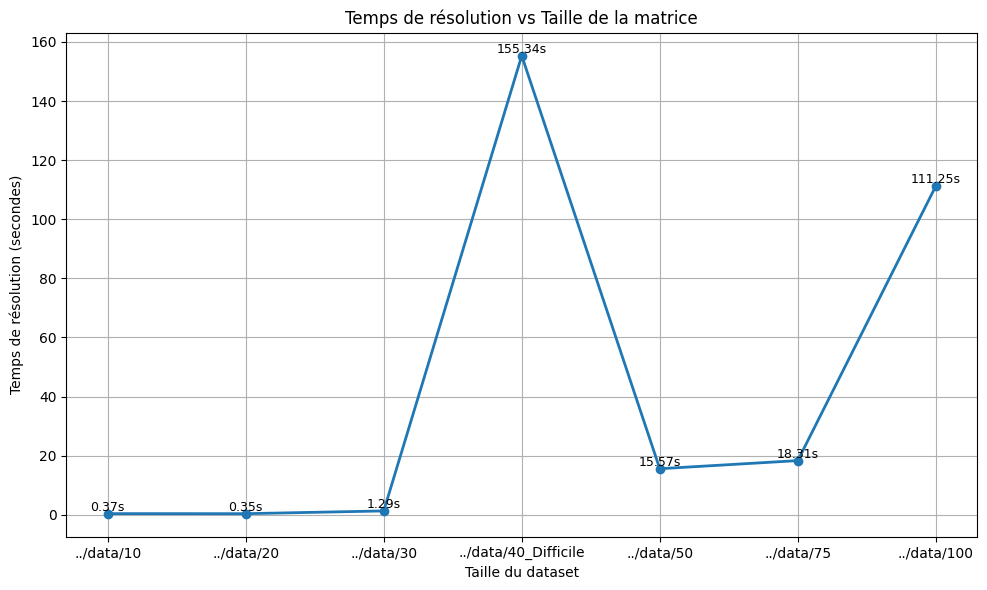

In [3]:
import pandas as pd
import pulp
import time
import matplotlib.pyplot as plt

file_list = [
    r"../data/matrice_routes_ordre_10.csv",
    r"../data/matrice_routes_ordre_20.csv",
    r"../data/matrice_routes_ordre_30.csv",
    r"../data/matrice_routes_ordre_40_Difficile.csv",
    r"../data/matrice_routes_ordre_50.csv",
    r"../data/matrice_routes_ordre_75.csv",
    r"../data/matrice_routes_ordre_100.csv"
]

results = []

for file in file_list:
    df = pd.read_csv(file, header=None)

    # Points de collecte
    collect_line = df.iloc[-1, 0]
    points_collecte = list(map(int, collect_line.split(';')))
    points_collecte = [p - 1 for p in points_collecte]
    non_collecte = [i for i in range(len(df) - 1) if i not in points_collecte]

    # Nettoyage de la matrice
    df = df.iloc[:-1]
    adj_matrix = df[0].str.split(';').apply(lambda x: list(map(int, x)))
    cost_matrix = pd.DataFrame(adj_matrix.tolist())
    INF = 10**6
    cost_matrix = cost_matrix.replace(-1, INF)
    n = cost_matrix.shape[0]

    # Modèle MILP
    prob = pulp.LpProblem("TSP", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(n)
                                    if i != j and cost_matrix.iloc[i, j] < INF), cat='Binary')
    u = pulp.LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

    prob += pulp.lpSum(cost_matrix.iloc[i, j] * x[i, j] for (i, j) in x)

    for i in range(n):
        prob += pulp.lpSum(x[i, j] for j in range(n) if (i, j) in x) == 1
        prob += pulp.lpSum(x[j, i] for j in range(n) if (j, i) in x) == 1

    for i in range(1, n):
        for j in range(1, n):
            if i != j and (i, j) in x:
                prob += u[i] - u[j] + n * x[i, j] <= n - 1

    # Contraintes spécifiques
    prob += pulp.lpSum(x[0, j] for j in points_collecte if (0, j) in x) == 1
    prob += pulp.lpSum(x[i, 0] for i in non_collecte if (i, 0) in x) == 1

    # Chrono
    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=300)
    start = time.time()
    prob.solve(solver)
    end = time.time()

    results.append({
        "taille": n,
        "temps": end - start,
        "nom": file.replace("matrice_routes_ordre_", "").replace(".csv", "")
    })

# === Affichage ===
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(df_results["nom"], df_results["temps"], marker='o', linewidth=2)
for i, row in df_results.iterrows():
    plt.text(row["nom"], row["temps"] + 1, f'{row["temps"]:.2f}s', ha='center', fontsize=9)
plt.xlabel("Taille du dataset")
plt.ylabel("Temps de résolution (secondes)")
plt.title("Temps de résolution vs Taille de la matrice")
plt.grid(True)
plt.tight_layout()
plt.show()

# === (Optionnel) Export CSV ou image ===
# df_results.to_csv("resultats_temps_resolution.csv", index=False)
# plt.savefig("temps_resolution_tendance.png")
